In [1]:
import warnings
from itertools import combinations

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.stats.qmc import LatinHypercube
from scipy.interpolate import LinearNDInterpolator

from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning

In [2]:
%load_ext autoreload
%autoreload 2
from common import *
from metrics import *
from shifty_kernels import ProjectionKernel, ConstantKernel, RBF, SymmetricKernel1D
from gaussian_process import NoiseFittedGP

In [3]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [4]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=True
save_dir = "../../../tex/03_gaussian_process_regression/img/"

## Analyzing the Dataset (Friedman Function)

In [5]:
dim = 5
sigma = .7
N = 1000
X = LatinHypercube(dim).random(N)
y = noisy_friedman(X, sigma=sigma)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)
y_train_mean = np.mean(y_train)
y_train = y_train - y_train_mean
y_test = y_test - y_train_mean

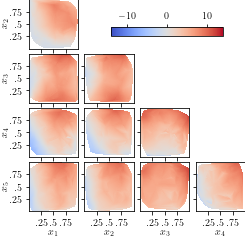

In [73]:
def my_formatter(x, pos):
    val_str = '{:g}'.format(x)
    if np.abs(x) > 0 and np.abs(x) < 1:
        return val_str.replace("0", "", 1)
    else:
        return val_str
    
interp = LinearNDInterpolator(X_train, y_train)
fig, ax = plt.subplots(nrows=dim - 1, ncols=dim - 1, figsize=(3.9,3.9), 
                       sharex=True, sharey=True)
planes = list(combinations(np.arange(5),2))
    
M = 100
dim = 5
x = y = np.linspace(0,1,M)
xx, yy = np.meshgrid(x,y)
fmax = np.max(y_train)
fmin = np.min(y_train)
halfrange=max(np.abs(fmin), np.abs(fmax))

major_formatter = FuncFormatter(my_formatter)
x_cross = 0.75
for plane_coordinates in planes:
    x = np.linspace(np.min(X_train[:,plane_coordinates[0]]),np.max(X_train[:,plane_coordinates[0]]),M)
    y = np.linspace(np.min(X_train[:,plane_coordinates[1]]),np.max(X_train[:,plane_coordinates[1]]),M)
    
    xx, yy = np.meshgrid(x,y)
    X = x_cross * np.ones((M*M,dim))
    X[:,plane_coordinates[0]] = xx.flatten()
    X[:,plane_coordinates[1]] = yy.flatten()
    fxy = interp(X).reshape(M,M)
    
    i, j = plane_coordinates[1] - 1, plane_coordinates[0]

    ax[i,j].grid(False)
    ax[i,j].set_box_aspect(1)
    im = ax[i,j].pcolormesh(xx,yy,fxy, cmap="coolwarm",
                      rasterized=True,
                      norm=colors.CenteredNorm(halfrange=halfrange))
    
    ax[i,j].xaxis.set_ticks(np.arange(0.25, 1, 0.25))
    ax[i,j].yaxis.set_ticks(np.arange(0.25, 1, 0.25))
    ax[i,j].xaxis.set_major_formatter(major_formatter)
    ax[i,j].yaxis.set_major_formatter(major_formatter)
    
ax[0,0].set_xlim([0,1])
ax[0,0].set_ylim([0,1])

for j in range(dim-1):
    ax[-1,j].set_xlabel(rf"$x_{j+1}$", color="k")
    ax[-1,j].xaxis.labelpad=0
    
for i in range(dim-1):
    ax[i,0].set_ylabel(rf"$x_{i+2}$", color="k")
    ax[i,0].yaxis.labelpad=0
    
for a in ax[np.triu_indices(dim - 1, 1)]:
    a.axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.42, 0.75, 0.4, 0.03])
cbar_ax.grid(False)

fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_label_position('top') 
cbar_ax.xaxis.tick_top()
cbar_ax.set_ylabel(r"y (interpolated)")

if save:
    fig.savefig(save_dir + f"friedman_crossections_x_{x_cross:.2f}.pdf",
                bbox_inches="tight",dpi=1000,pad_inches = 0.01)
else:
    plt.show()

## Kernel Comparison

In [8]:
# Generates trivial projection matrix in x_{direction} 
def P(dim, direction):
    P_x = np.zeros((dim,dim))
    P_x[direction,direction] = 1
    return P_x

sqexp = ConstantKernel(constant_value=1) * RBF(length_scale=[0.1])
coupling = ConstantKernel(constant_value=1) * ProjectionKernel(sqexp, P(dim, 0), tag="x0") * ProjectionKernel(sqexp, P(dim, 1), tag="x1")
kernels = {
    "sq_exp":sqexp,
    "sq_exp_ard":(ConstantKernel(constant_value=1) * RBF(length_scale=dim * [0.1])),
    "sq_exp_i12345":  ProjectionKernel(sqexp, P(dim, 0), tag="x1") \
                         + ProjectionKernel(sqexp, P(dim, 1), tag="x2") \
                         + ProjectionKernel(sqexp, P(dim, 2), tag="x3") \
                         + ProjectionKernel(sqexp, P(dim, 3), tag="x4") \
                         + ProjectionKernel(sqexp, P(dim, 4), tag="x5"),
    "sq_exp_c12_i345":  coupling + ProjectionKernel(sqexp, P(dim, 2), tag="x3") \
                                              + ProjectionKernel(sqexp, P(dim, 3), tag="x4") \
                                              + ProjectionKernel(sqexp, P(dim, 4), tag="x5"),
    "sq_exp_c12_s3_i45":  coupling + SymmetricKernel1D(ProjectionKernel(sqexp, P(dim, 2), tag="x3"), offset=0.5) \
                                                   + ProjectionKernel(sqexp, P(dim, 3), tag="x4") \
                                                   + ProjectionKernel(sqexp, P(dim, 4), tag="x5")
}


In [9]:
hyperparameters = {
    "n_restarts_optimizer": 10
}
prediction_error={}
prediction_error_std={}
trained_gp={}

warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

train = True
for name, kernel in kernels.items():
        if train:
            print(f"Training {name}")
            gp = NoiseFittedGP(kernel=kernel, **hyperparameters)
            prediction_error[name], prediction_error_std[name], trained_gp[name] = prediction_error_CV(squared_error, gp, 
                                                                                                       X_train, y_train, nfolds=10, return_best_predictor=True)
            trained_gp[name].save(name)
        else:
            print(f"Loading {name}")
            trained_gp[name] = NoiseFittedGP.load(name)
            
        print(f"Trained kernel: {trained_gp[name].kernel_}")

Training sq_exp
Trained kernel: 21.6**2 * RBF(length_scale=1.13) + WhiteKernel(noise_level=0)
Training sq_exp_ard
Trained kernel: 193**2 * RBF(length_scale=[1.65, 1.59, 4.3, 41, 76.2]) + WhiteKernel(noise_level=0)
Training sq_exp_i12345
Trained kernel: ProjectionKernel(x1, 19.3**2 * RBF(length_scale=1.36)) + ProjectionKernel(x2, 4.02**2 * RBF(length_scale=0.512)) + ProjectionKernel(x3, 17.5**2 * RBF(length_scale=1.1)) + ProjectionKernel(x4, 29.5**2 * RBF(length_scale=4.17)) + ProjectionKernel(x5, 19.7**2 * RBF(length_scale=4.57)) + WhiteKernel(noise_level=0)
Training sq_exp_c12_i345
Trained kernel: 0.798**2 * ProjectionKernel(x0, 25.5**2 * RBF(length_scale=0.767)) * ProjectionKernel(x1, 0.778**2 * RBF(length_scale=0.684)) + ProjectionKernel(x3, 12.9**2 * RBF(length_scale=0.977)) + ProjectionKernel(x4, 10**2 * RBF(length_scale=1.47)) + ProjectionKernel(x5, 22.5**2 * RBF(length_scale=6.48)) + WhiteKernel(noise_level=0)
Training sq_exp_c12_s3_i45
Trained kernel: 1.13**2 * ProjectionKernel

### Cross validated SMSE across different kernels

SMSE = [0.02464517 0.26014593 0.09637338 0.02024761 0.01988742]
Lower Bound = 0.019356561116637198


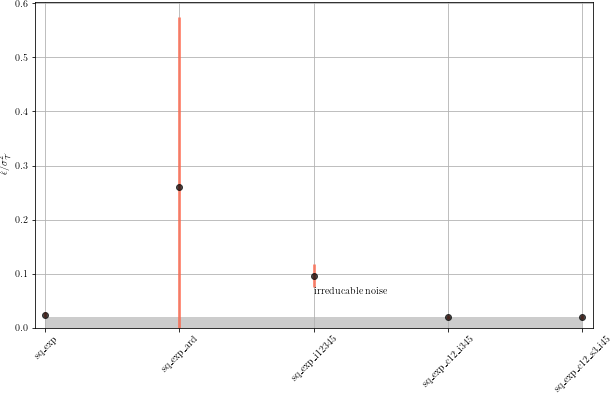

In [11]:
size = (10,6)
fig, ax = plt.subplots(figsize=size)
ax.margins(0.02)

#Convert to standardized MSE (trivial model has SMSE=1)
test_variance = np.var(y_test)
smse_kernel, smse_errors = list(prediction_error.keys()), np.array(list(prediction_error.values()))/test_variance
smse_errors_std = np.array(list(prediction_error_std.values()))/test_variance
print(f"SMSE = {smse_errors}")
print(f"Lower Bound = {sigma**2/test_variance}")

upper_error = smse_errors_std
lower_error = np.minimum(smse_errors, smse_errors_std)

asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

ax.errorbar(smse_kernel, smse_errors, yerr=asymmetric_error, fmt='o', color='black',
             ecolor='tomato', elinewidth=3, capsize=0, alpha=.7);
ax.fill_between(smse_kernel, 0, sigma**2/test_variance, alpha=0.4, color="gray", edgecolor=None)
ax.set_ylabel(r"$\hat\epsilon/\sigma^2_\mathcal{T}$")
ax.set_ylim(0, 1.05*np.max(upper_error+smse_errors))
ax.text(0.5, 0.1, r"irreducable noise", transform=ax.transAxes)
ax.xaxis.set_tick_params(rotation=45)
plt.show()

### Regression Result for Optimized Kernel

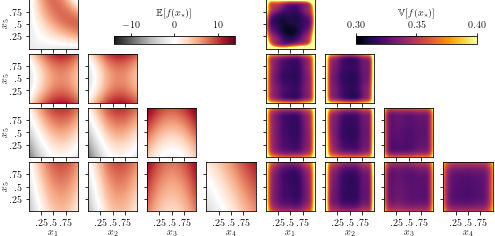

In [167]:
fig, ax = plt.subplots(nrows=dim - 1, ncols=2 * (dim - 1), figsize=(8.4,3.9), 
                       sharex=True, sharey=True)
planes = list(combinations(np.arange(5),2))
x_cross=0.75
    
sigma_min = 0.3
sigma_max = 0.4
for plane_coordinates in planes:
    x = np.linspace(np.min(X_train[:,plane_coordinates[0]]),np.max(X_train[:,plane_coordinates[0]]),M)
    y = np.linspace(np.min(X_train[:,plane_coordinates[1]]),np.max(X_train[:,plane_coordinates[1]]),M)
    
    xx, yy = np.meshgrid(x,y)
    X = x_cross * np.ones((M*M,dim))
    X[:,plane_coordinates[0]] = xx.flatten()
    X[:,plane_coordinates[1]] = yy.flatten()
    f, sigma_f = trained_gp["sq_exp_c12_i345"].predict(X, return_std=True)
    f = f.reshape(M,M)
    sigma_f = sigma_f.reshape(M,M)
    
    i, j = plane_coordinates[1] - 1, plane_coordinates[0]

    ax[i,j].grid(False)
    ax[i,j].set_box_aspect(1)
    ax[i,dim - 1 + j].grid(False)
    ax[i,dim - 1 + j].set_box_aspect(1)
    
    im = ax[i,j].pcolormesh(xx,yy,f, cmap="RdGy_r", 
                            norm=colors.CenteredNorm(halfrange=halfrange),
                            rasterized=True)
    im2 = ax[i, dim-1+j].pcolormesh(xx,yy,np.sqrt(sigma_f), cmap="inferno", 
                                    vmin=sigma_min, vmax=sigma_max,
                                    rasterized=True)
    
    for a in [ax[:,:dim-1], ax[:, dim-1:]]:
        a[i,j].yaxis.set_ticks(np.arange(0.25, 1, 0.25))
        a[i,j].yaxis.set_major_formatter(major_formatter)
        a[i,j].xaxis.set_ticks(np.arange(0.25, 1, 0.25))
        a[i,j].xaxis.set_major_formatter(major_formatter)
    
ax[0,0].set_xlim([0,1])
ax[0,0].set_ylim([0,1])

for j in range(dim-1):
    ax[-1,j].set_xlabel(rf"$x_{j+1}$", color="k")
    ax[j,0].set_ylabel(rf"$x_{i+2}$", color="k")
    ax[-1,j].xaxis.labelpad=0
    ax[-1,dim-1+j].set_xlabel(rf"$x_{j+1}$", color="k")
    ax[-1,dim-1+j].xaxis.labelpad=0
    ax[j,0].yaxis.labelpad=0
    
for a in [ax[:,:dim-1], ax[:, dim-1:]]:
    for aa in a[np.triu_indices(dim - 1, 1)]:
        aa.axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

cbar_ax = fig.add_axes([0.27, 0.72, 0.2, 0.03])
cbar_ax2 = fig.add_axes([0.67, 0.72, 0.2, 0.03])
label = [r"$\mathbb{E}[f(x_{*})]$", r"$\mathbb{V}[f(x_{*})]$"]
ims = [im, im2]
for cbar_a,l,im in zip([cbar_ax, cbar_ax2],label, ims):
    cbar_a.grid(False)
    cbar = fig.colorbar(im, cax=cbar_a, orientation="horizontal")
    cbar.set_label(l)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.ax.xaxis.tick_top()

if save:
    fig.savefig(save_dir + f"friedman_crossections_gp_x_{x_cross:.2f}.pdf",
                bbox_inches="tight",dpi=1000,pad_inches = 0.01)
else:
    plt.show()

In [173]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
        
    return corr_array[idx, :][:, idx]

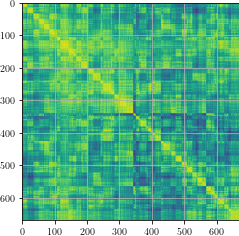

In [174]:
K = trained_gp["sq_exp"].kernel_(X_train, X_train)
plt.imshow(cluster_corr(K))